In [169]:
def clock(repeats):
    def time_decorator(f):
        @wraps(f)
        def wrap(*args, **kwargs):
            measurements = []
            for _ in range(repeats):
                t = time()
                res = f(*args, **kwargs)
                measurements += [time()-t]
            return res, np.mean(measurements)
        return wrap
    return time_decorator        

In [134]:
r_num = 25


@clock(repeats = r_num)
def mat_mul(A, B):
    C = np.zeros(A.shape)
    n = len(C[0])
    for i in range(n):
        for j in range(n):
            for k in range(n):
                C[i, j] += A[i, k]*B[k, j]
    return C

In [135]:
def benchmark_mat(f, n = 500):
    measurements = []
    timestomps = np.array([16,32, 64,128,256])#np.arange(50, n, 10)
    for i in timestomps:
        A = np.random.random([i, i])*10
        B = np.random.random([i, i])*10
        measurements += [f(A, B)[1]]
    return timestomps, np.array(measurements)

In [136]:
def split(matrix):  # split matrix into quarters
    row, col = matrix.shape
    return matrix[:row//2, :col//2], matrix[:row//2, col//2:], matrix[row//2:, :col//2], matrix[row//2:, col//2:]

@clock(repeats = r_num)
def strass(a, b):
    def strassen(a, b):
        q = len(a)
        if q == 1:  # base case: 1x1 matrix
            return a * b
        a11, a12, a21, a22 = split(a)
        b11, b12, b21, b22 = split(b)
        p1 = strassen(a11 + a22, b11 + b22)  # p1 = (a11 + a22) * (b11 + b22)
        p2 = strassen(a21 + a22, b11)        # p2 = (a21 + a22) * b11
        p3 = strassen(a11, b12 - b22)        # p3 = a11 * (b12 - b22)
        p4 = strassen(a22, b21 - b11)        # p4 = a22 * (b21 - b11)
        p5 = strassen(a11 + a12, b22)        # p5 = (a11 + a12) * b22
        p6 = strassen(a21 - a11, b11 + b12)  # p6 = (a21 - a11) * (b11 + b12)
        p7 = strassen(a12 - a22, b21 + b22)  # p7 = (a12 - a22) * (b21 + b22)
        c11 = p1 + p4 - p5 + p7  # c11 = p1 + p4 - p5 + p7
        c12 = p3 + p5            # c12 = p3 + p5
        c21 = p2 + p4            # c21 = p2 + p4
        c22 = p1 + p3 - p2 + p6  # c22 = p1 + p3 - p2 + p6
        c = np.vstack((np.hstack((c11, c12)), np.hstack((c21, c22)))) 
        return c
    return strassen(a, b)


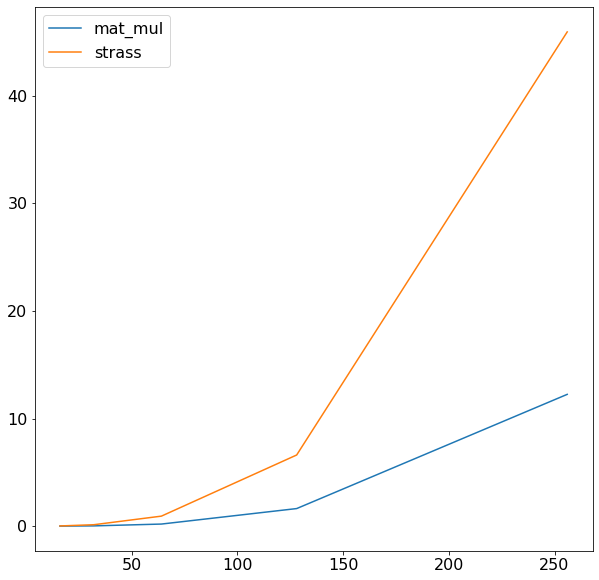

In [196]:
plt.figure(figsize=(10, 10))
for f in [mat_mul, strass]:
    bench = benchmark_mat(f, 100)
    plt.plot(bench[0], bench[1], label = f.__name__)
plt.legend()
plt.savefig('matmul8.png')
plt.show()

In [187]:
def F(x, a, b):
    return a*x + b

def G(x, a, b):
    return a/(1 + b*x)

In [188]:
def loss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

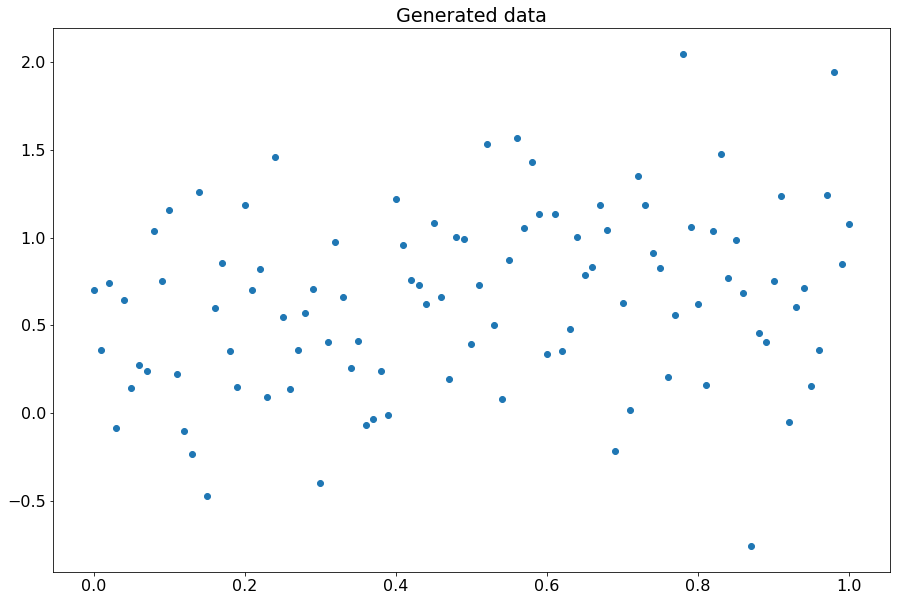

In [189]:
#alpha = np.random.rand()
#beta = np.random.rand()
    
#x = np.arange(0, 1.01, step=0.01)
#y = alpha*x + beta + np.random.normal(loc=0, scale=0.5, size=x.shape)

def linear_objective(p):
    return loss(F(x, p[0], p[1]), y)
    
def rational_objective(p):
    return loss(G(x, p[0], p[1]), y)

plt.figure(figsize=(15, 10))
plt.title('Generated data')
plt.scatter(x, y)
plt.savefig('data3.png')

In [201]:
def gradient_descent(f, x_0, eps, alpha):
    grad_f = grad(f)
    x_cur = x_0
    x_next = x_cur - alpha*grad_f(x_cur)
    i = 1
    while euclidean(x_cur, x_next) > eps:
        x_cur = x_next
        x_next = x_cur - alpha*grad_f(x_cur)
        i += 1
    return x_cur, i

    
def Adam(f, theta, alpha=0.001, beta1=0.7, beta2=0.999, eps=1e-2):
    m = 0
    v = 0
    t = 0
    i = 0
    first_iter = True
    theta1 = theta
    while (euclidean(theta, theta1)>eps) or first_iter:
        first_iter = False
        theta = theta1
        t += 1
        m = beta1*m + (1-beta1)*grad(f)(theta)
        v = beta2*v + (1-beta2)*grad(f)(theta)**2
        m_hat = m/(1 - beta1**t)
        v_hat = v/(1 - beta2**t)
        theta1 = theta - alpha*(m_hat/(np.sqrt(v_hat)-eps))
        i+=1
    return theta1, i
    
    

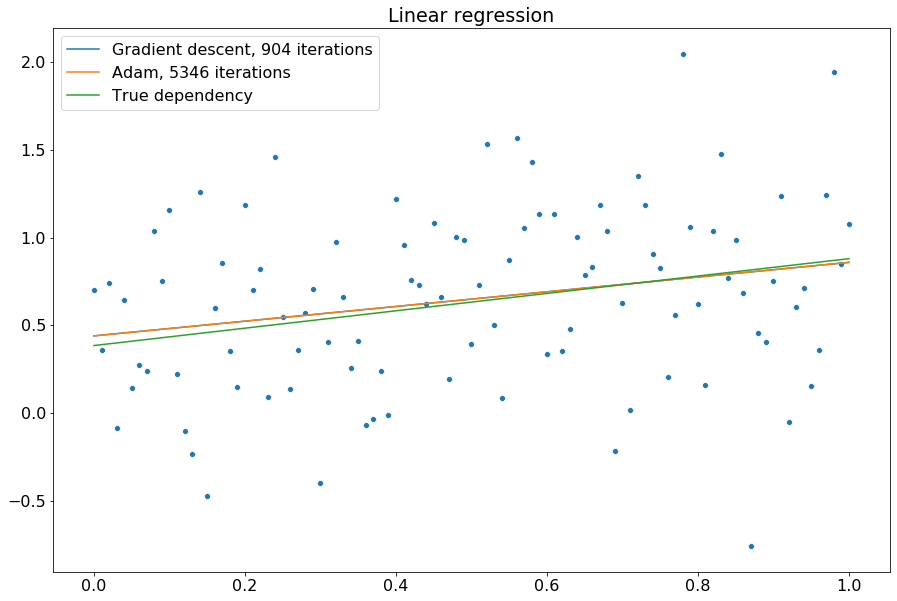

In [202]:
p_1, n_it_1 = gradient_descent(linear_objective, np.array([0., 0.]), alpha=0.001, eps=1e-8)
p_2, n_it_2 = Adam(linear_objective, np.array([0., 0.]), eps=1e-8)
y_pred_1 = F(x, *p_1)
y_pred_2 = F(x, *p_2)
y_true = F(x, alpha, beta)

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 16})
sns.scatterplot(x, y)
plt.plot(x, y_pred_1, label=f'Gradient descent, {n_it_1} iterations')
plt.plot(x, y_pred_2, label=f'Adam, {n_it_2} iterations')
plt.plot(x, y_true, label='True dependency')
plt.legend()
plt.title('Linear regression')
plt.savefig('linear7.png')